Based on this Medium article:

https://medium.com/wwblog/time-series-clustering-based-on-autocorrelation-using-python-94d5e3475179

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas statsmodels matplotlib scikit-learn

In [3]:
from statsmodels.tsa.arima_process import ArmaProcess
import pandas
import matplotlib.pyplot as plt

processes = [
    ArmaProcess.from_coeffs([], []),       # White noise
    ArmaProcess.from_coeffs([-0.5], []),   # AR(1) 
    ArmaProcess.from_coeffs([], [0.9]),    # MA(1)
    ArmaProcess.from_coeffs([0.5], [0.5])  # ARMA(1, 1)
]

# Now we have four DGPs (data generating processes), so we can use them to sample data.

# Number of time series per process
series_per_process = 3

# Length of an individual time series
T = 1_000

n_processes = len(processes)
n_series = n_processes * series_per_process

# Generate the time series.
df = pandas.DataFrame({
    f'TS_{i}': processes[i // series_per_process].generate_sample(T)
    for i in range(n_series)
})

print([i // series_per_process for i in range(n_series)])

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]


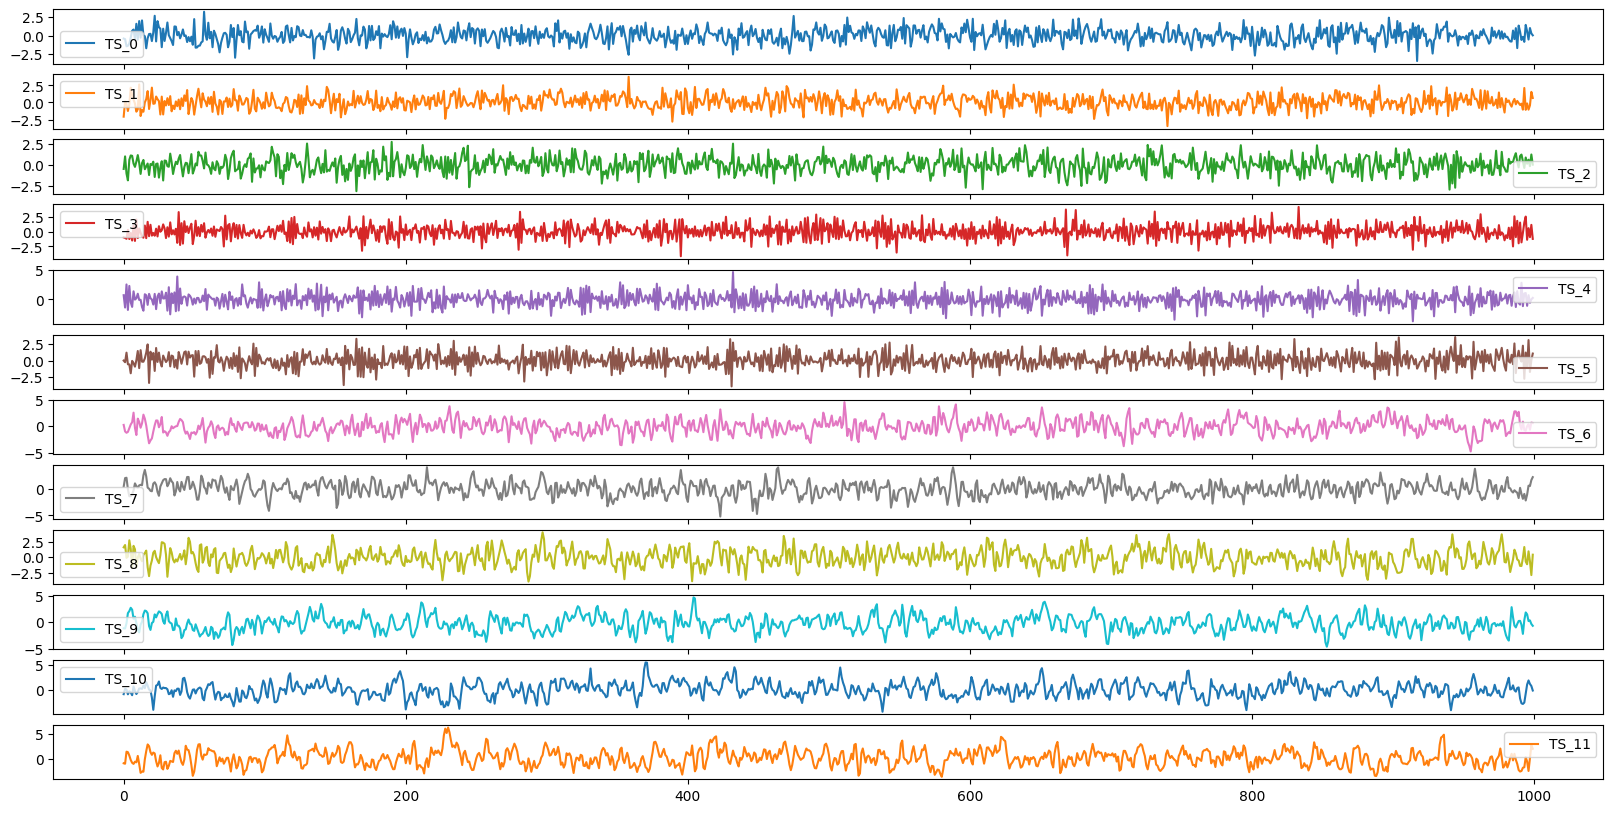

In [4]:
df.plot(subplots=True, figsize=(20, 10))
_ = plt.legend(loc='best')

## Autocorrelation function (ACF)

For a given time series and a lag - the number of time steps between two values in the series - there's a set of all value pairs having that lag between them.
A lag of 3 has pairs `{(t=0, t=3), (t=1, t=4), (t=2, t=5), ...}`.
You can measure the correlation of time series values for that set, which yields an informative statistic reguarding the time series.

For any given series, the function that maps the lags `L >= 0` to their corresponding correlations is called the autocorrelation function.
It is a vector, and we can estimate it from sample data.

In [5]:
import statsmodels.tsa.stattools
import numpy as np
import pandas as pd

def acf(x, n_lags):
    return statsmodels.tsa.stattools.acf(x, nlags=n_lags)

# Max ACF lags, those that we care about for the feature vector
n_lags = 20

lag_arr = np.repeat(n_lags, df.shape[1])

acf_list = list(map(
    acf,
    df.transpose().to_numpy(),
    lag_arr
))

acf_df = pd.DataFrame(acf_list).transpose()
acf_df.columns = df.columns
acf_df


,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.034156,-0.011906,0.004151,-0.532334,-0.527434,-0.492716,0.490309,0.510900,0.479790,0.694068,0.693624,0.713412
2,0.023149,0.047839,-0.001380,0.278751,0.282309,0.256460,0.017867,0.024195,-0.015359,0.321746,0.316563,0.358508
3,-0.057353,-0.014888,-0.045246,-0.121174,-0.155101,-0.158676,0.051362,0.011384,0.006092,0.148743,0.130767,0.180595
4,-0.003159,0.040879,-0.003992,0.041340,0.027797,0.112814,0.017690,-0.005241,-0.031219,0.085093,0.061902,0.095732
5,0.029128,-0.060059,-0.053297,-0.001759,-0.035406,-0.056914,0.001085,-0.031633,-0.053545,0.049706,0.038827,0.067563
6,-0.009591,0.010926,-0.025847,0.035706,0.034959,0.039749,0.048795,-0.032869,-0.012329,0.028595,0.034076,0.064521
7,-0.018057,0.016508,0.009263,-0.065570,-0.026477,-0.021680,0.069778,0.012345,-0.022050,0.037666,0.037757,0.075727
8,0.022271,0.008114,-0.024938,0.086822,0.011734,0.009312,0.060720,0.030241,-0.063662,0.077375,0.045048,0.059583
9,-0.000950,0.002988,-0.010795,-0.041240,0.023174,0.028463,0.082223,-0.013221,-0.058851,0.081309,0.045252,0.036810


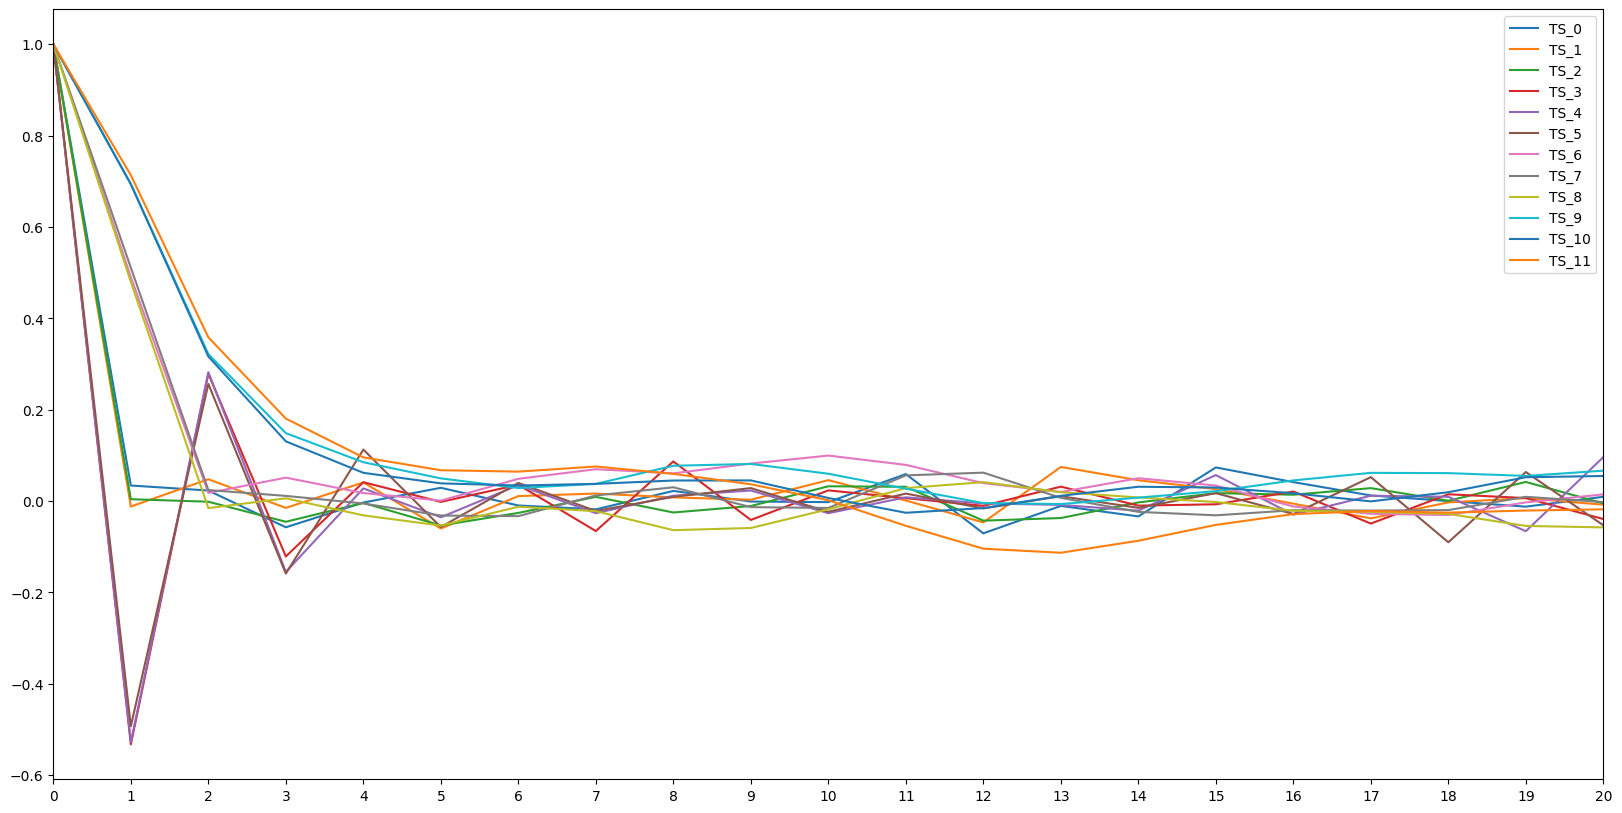

In [6]:
axes = acf_df.plot(figsize=(20, 10))
axes.set_xlim(left=0, right=acf_df.shape[0]-1)
axes.set_xticks(range(acf_df.shape[0]))
_ = plt.legend(loc='best')


There are four distinct clusters based on this plot at the lower lag values.
Notice how at `l=1`, there are four line groups, each with lines very close to each other and distinctively far away from other line groups.
This makes sense considering we employed four distinct DGPs.

The line group at `(x = 1, y ~= 0)` ought to correspond to the white noise DGPs since it hovers around 0, suggesting uncorrelated values.

It turns out that both autoregression (AR) and moving averages (MA) induce autocorrelation, so the other three clusters correspond to those.

## Clustering the Time Series Computationally

Let's use *k*-means clustering.
We are kind of cheating by knowing the value of *k*, but this can be resolved in the future by looking at clustering indices for varying values of *k*.

In [7]:
from sklearn.cluster import KMeans

n_clusters = n_processes
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')\
    .fit(acf_df.transpose())

kmeans.labels_

array([2, 2, 2, 1, 1, 1, 0, 0, 0, 3, 3, 3], dtype=int32)

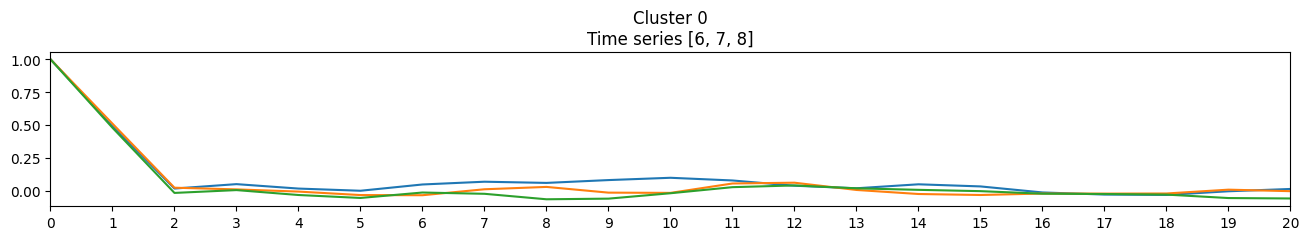

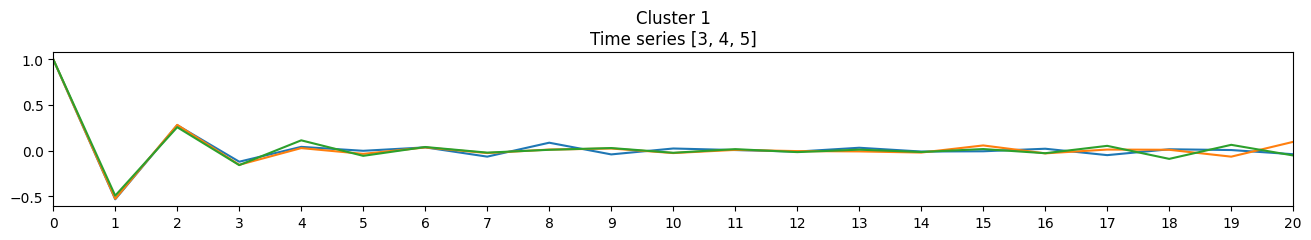

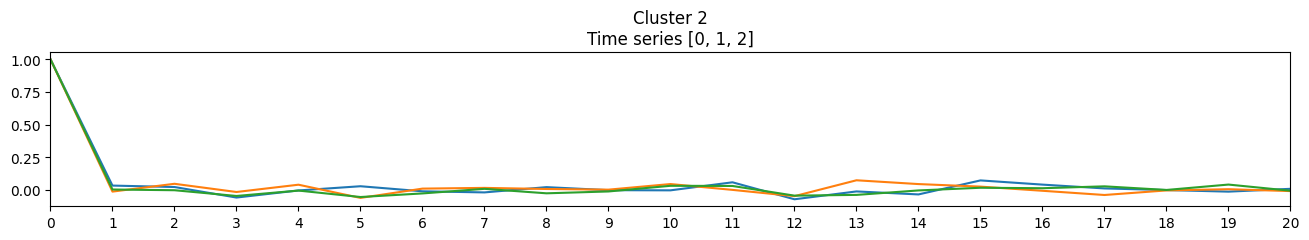

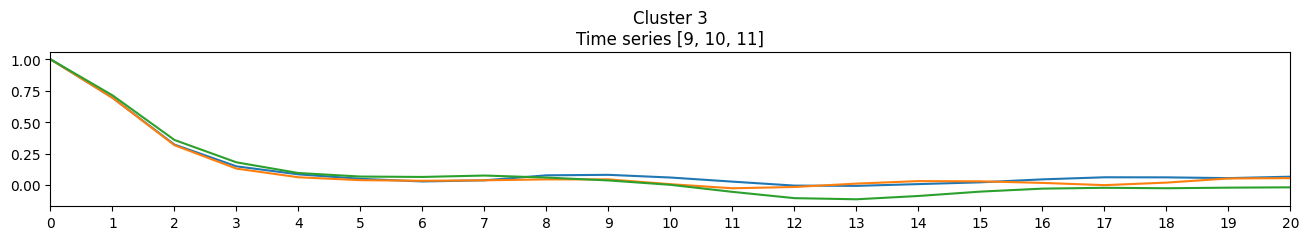

In [8]:
# i ranges over clusters
for i in range(n_clusters):
    plt.figure(figsize=(16, 2))
    plt.xlim((1, n_lags))

    ts = []
    
    # j ranges over the series ACFs
    for j in range(n_series):
        
        # Plot ACF j in the current cluster i
        if kmeans.labels_[j] == i:
            ts.append(j)
            plt.plot(acf_df.iloc[:, j])
            plt.xticks(range(acf_df.shape[0]))

        plt.title(f"Cluster {i}\nTime series {ts}")
        
plt.show()

So, we've clustered some time series using ACF estimates as a feature vector, and using *k*-means to perform the clustering.
There are some alternatives:

* Sticking with features, some other time-domain features such as PACF, quantile auto covariance, and others
* Frequency-domain or wavelet-domain features are feasible too
* Features are not necessary; there are observation-based and model-based clustering too
* Other distance measures besides Euclidean may be appropriate
* Crisp or fuzzy clustering is doable

See "Time Series Clustering and Classification" by Maharaj et. al.

Let's now vary `k` to dynamically choose the value of `k` that produces the best fit.

For n_clusters = 2 The average silhouette_score is : 0.7049787496083261
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.561464362648773
For n_clusters = 6 The average silhouette_score is : 0.4857596147013468


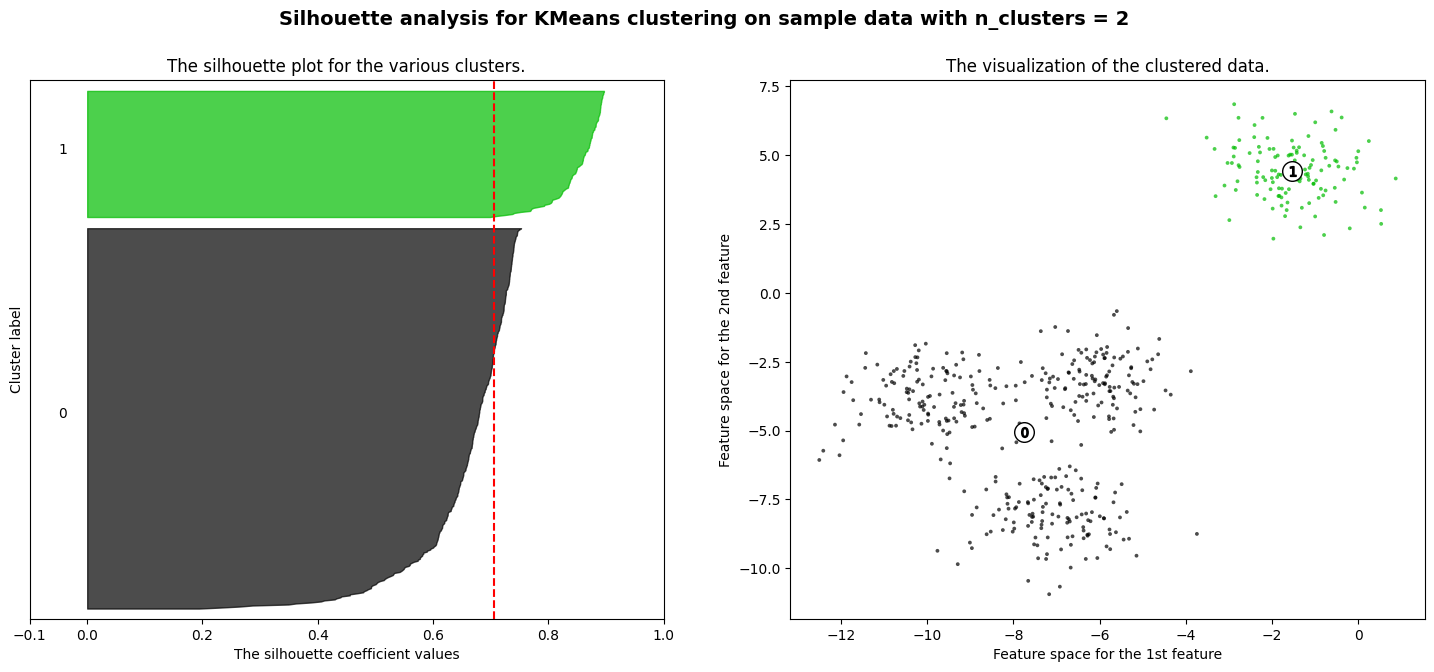

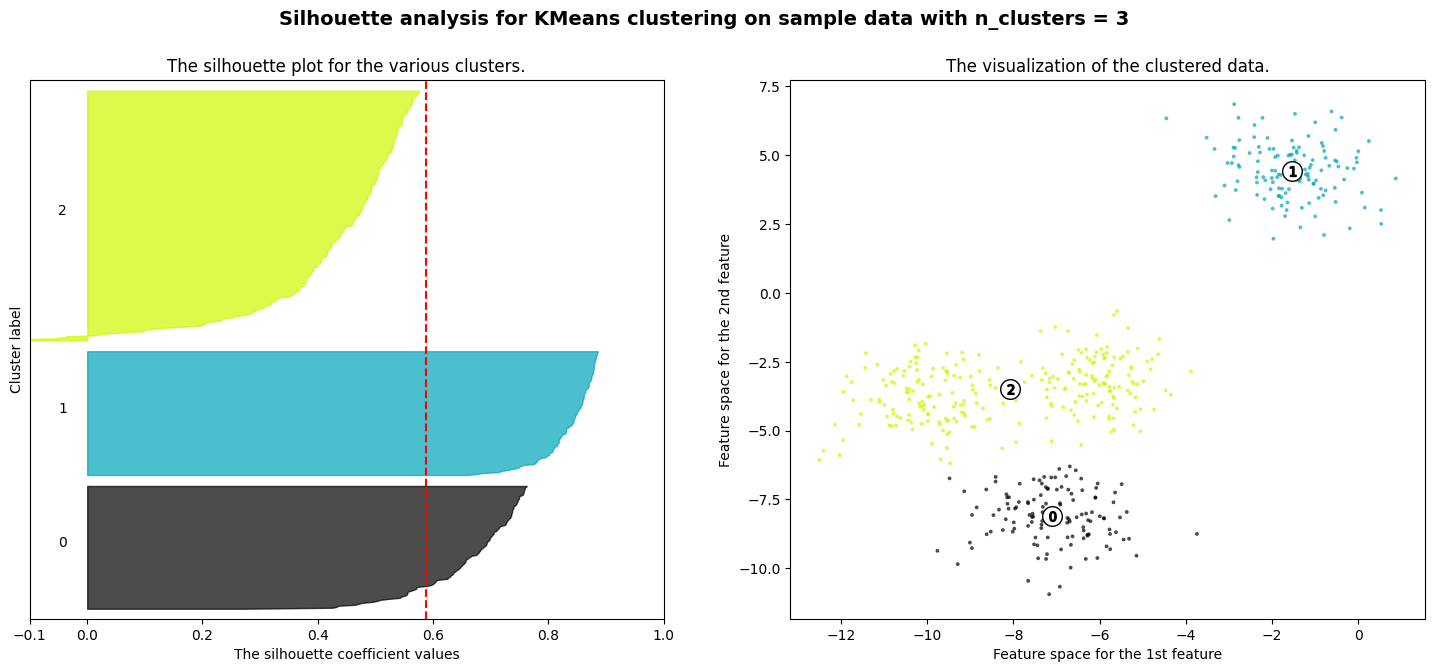

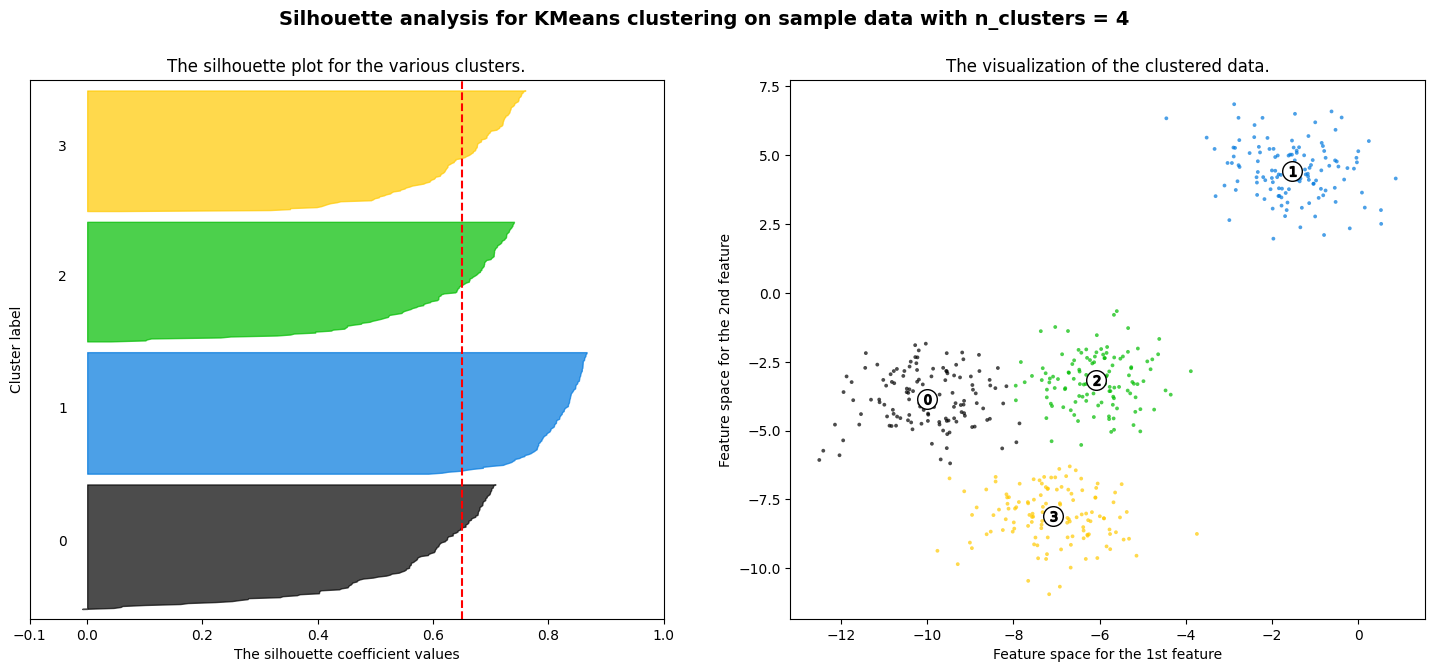

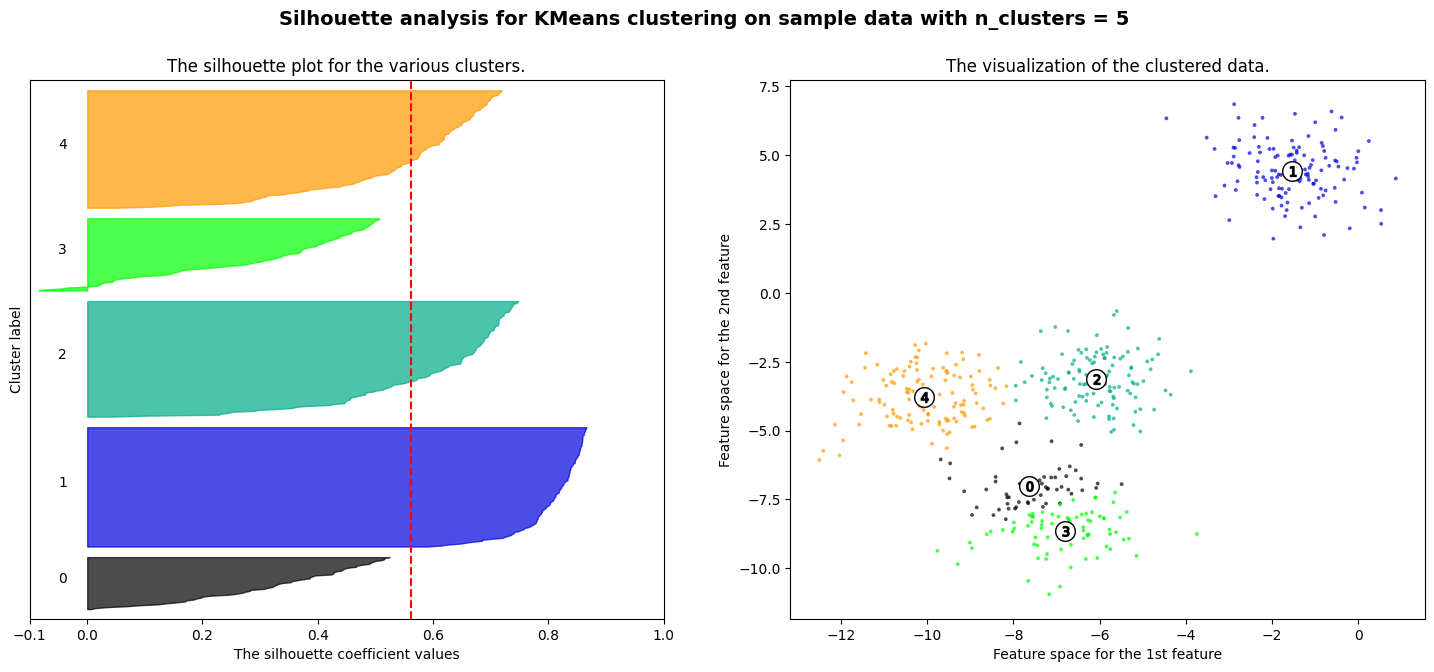

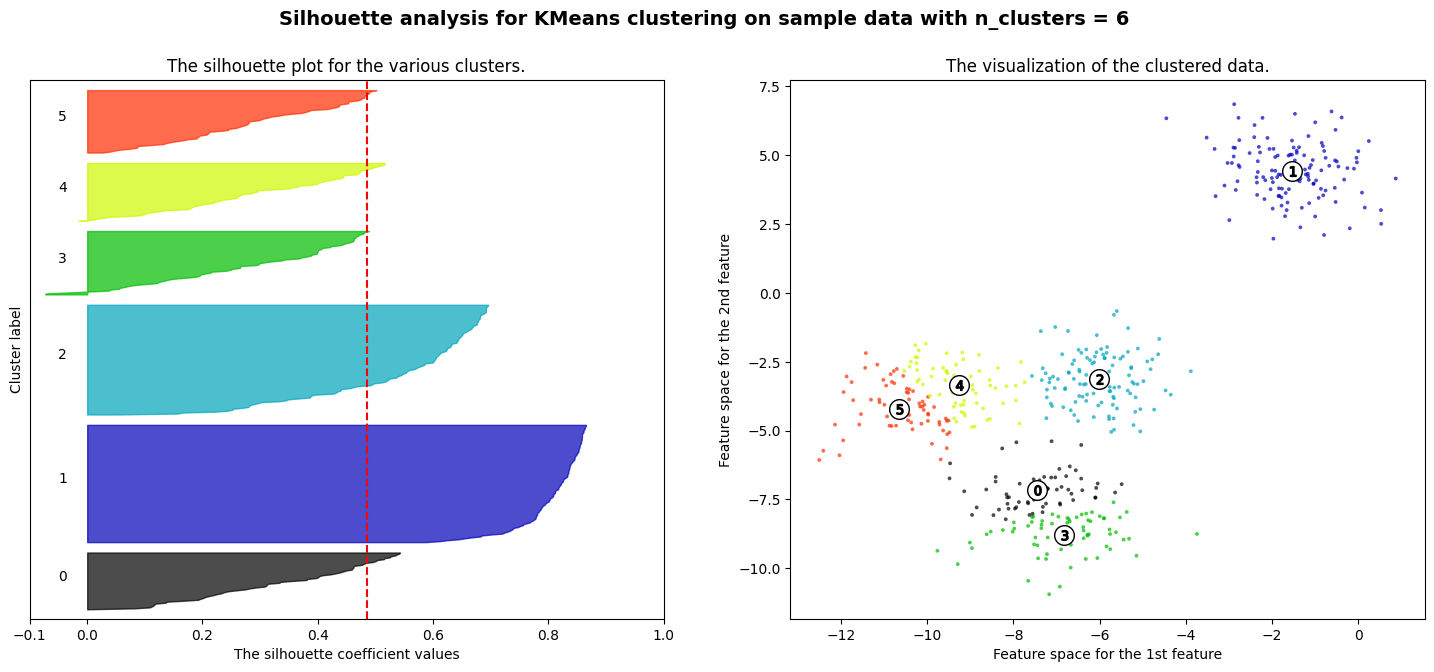

In [11]:
# Produce a Silhouette plot for k=4

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()